<a href="https://colab.research.google.com/github/Palaeoprot/IPA/blob/main/ModulAAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://drive.google.com/uc?export=view&id=1jmpFC9fmDMGKNuhGMdjMvKMXDOcW5iO2' width=700px align=centre>



In [1]:
#@title  Packages and Globlal Variables
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
import json
import gspread
import random
from scipy.optimize import differential_evolution
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import logging
from typing import List, Dict, Tuple
import configparser
import argparse

#from scipy.optimize import curve_fit
#from scipy.optimize import differential_evolution
#from scipy.interpolate import interp1d


# Precomputed activation energies in kJ/mol (converted to J/mol)
activation_energies = {
    'Asx_ConcTHAA': 111.09 * 1000,
    'Asx_ConcFAA': 98.93 * 1000, 'Asx_DLTHAA': 126.02 * 1000, 'Asx_DLFAA': 121.99 * 1000, 'Glx_ConcTHAA': 105.46 * 1000, 'Glx_ConcFAA': 109.39 * 1000, 'Glx_DLTHAA': 121.89 * 1000,
    'Glx_DLFAA': 100.80 * 1000, 'Ser_ConcTHAA': 127.59 * 1000, 'Ser_ConcFAA': 97.95 * 1000, 'Ser_DLTHAA': 123.03 * 1000, 'Ser_DLFAA': 116.72 * 1000, 'Ala_ConcTHAA': 96.58 * 1000,
    'Ala_ConcFAA': 112.12 * 1000, 'Ala_DLTHAA': 113.58 * 1000, 'Ala_DLFAA': 98.88 * 1000, 'Val_ConcTHAA': 111.00 * 1000, 'Val_ConcFAA': 122.81 * 1000,
    'Val_DLTHAA': 99.73 * 1000, 'Val_DLFAA': 128.52 * 1000, 'Phe_ConcTHAA': 113.28 * 1000, 'Phe_ConcFAA': 98.88 * 1000, 'Phe_DLTHAA': 128.15 * 1000, 'Phe_DLFAA': 102.27 * 1000, 'Leu_ConcTHAA': 114.09 * 1000,
    'Leu_ConcFAA': 103.75 * 1000, 'Leu_DLTHAA': 105.43 * 1000, 'Leu_DLFAA': 105.43 * 1000, 'Ile_ConcTHAA': 114.09 * 1000, 'Ile_ConcFAA': 103.75 * 1000, 'Ile_DLTHAA': 105.43 * 1000, 'Ile_DLFAA': 105.43 * 1000
}

# Define the mapping from one-letter to three-letter amino acid codes
one_to_three_letter = {
    "I": "Ile", "V": "Val", "L": "Leu", "F": "Phe", "C": "Cys", "M": "Met",
    "A": "Ala", "G": "Gly", "T": "Thr", "W": "Trp", "S": "Ser", "Y": "Tyr",
    "P": "Pro", "H": "His", "Q": "Gln", "E": "Glx", "N": "Asn", "D": "Asx",
    "K": "Lys", "R": "Arg", "D": "Asx", "E": "Glx"
}

# Pre-exponential factors for each type of rate (example values)
pre_exponential_factors = {
    'Asx': {'internal': 1e19, 'terminal': 1e20, 'free': 1e18, 'loss': 1e18},
    'Glx': {'internal': 1e17, 'terminal': 1e20, 'free': 1e17, 'loss': 1e16},
    'Ser': {'internal': 1e19, 'terminal': 1e20, 'free': 1e20, 'loss': 1e15},
    'Ala': {'internal': 1e17, 'terminal': 1e17, 'free': 1e16, 'loss': 1e20},
    'Val': {'internal': 1e17, 'terminal': 1e20, 'free': 1e15, 'loss': 1e10},
    'Phe': {'internal': 1e17, 'terminal': 1e17, 'free': 1e20, 'loss': 1e15},
    'Leu': {'internal': 1e19, 'terminal': 1e18, 'free': 1e13, 'loss': 1e20},
    'Ile': {'internal': 1e16, 'terminal': 1e20, 'free': 1e18, 'loss': 1e20}
}

# Define a mapping from rate type descriptions to pre-exponential factor keys
rate_type_mapping = {
    'ConcTHAA': 'internal',
    'ConcFAA': 'terminal',
    'DLTHAA': 'free',
    'DLFAA': 'loss'
}

# Function to calculate the rate constant using the Arrhenius equation with pre-exponential
# Universal gas constant in J/(mol·K)
R = 8.314

def arrhenius_rate_constant(E_a, T, A):
    return A * np.exp(-E_a / (R * T))


In [2]:
#@title Colours
# Load color dictionary
color_dict_path = '/content/drive/MyDrive/Colab_Notebooks/Dictionaries/Colours/colors.json'
with open(color_dict_path, 'r') as file:
    color_dict = json.load(file)


# Amino acid colors
amino_acid_colors = color_dict["amino_acids_colors"]
one_to_three_letter = {'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp', 'C': 'Cys', 'E': 'Glu', 'Q': 'Gln',
                       'G': 'Gly', 'H': 'His', 'I': 'Ile', 'L': 'Leu', 'K': 'Lys', 'M': 'Met', 'F': 'Phe',
                       'P': 'Pro', 'S': 'Ser', 'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'}


# Create a dictionary mapping three-letter codes to concentration column names
three_letter_to_Conc = {
    'Ala': '[Ala]', 'Arg': '[Arg]', 'Asn': '[Asx]', 'Asp': '[Asx]', 'Cys': '[Cys]',
    'Glu': '[Glx]', 'Gln': '[Glx]', 'Gly': '[Gly]', 'His': '[His]', 'Ile': '[Ile]',
    'Leu': '[Leu]', 'Lys': '[Lys]', 'Met': '[Met]', 'Phe': '[Phe]', 'Pro': '[Pro]',
    'Ser': '[Ser]', 'Thr': '[Thr]', 'Trp': '[Trp]', 'Tyr': '[Tyr]', 'Val': '[Val]'
}

# Create a color dictionary for three-letter codes
amino_acid_colors_three_letter = {one_to_three_letter[k]: v for k, v in amino_acid_colors.items() if k in one_to_three_letter}

# Create the final color dictionary for concentration column names
amino_acid_colors_conc = {three_letter_to_Conc[k]: v for k, v in amino_acid_colors_three_letter.items() if k in three_letter_to_Conc}


# Function to adjust color saturation
def adjust_saturation(color, amount=0.5):
    color = mcolors.to_rgba(color)
    color = mcolors.rgb_to_hsv(color[:3])
    color[1] = max(0, min(1, color[1] * amount))
    return mcolors.hsv_to_rgb(color)

# Adjust colors for standard deviations
std_colors = {k: adjust_saturation(v, 0.5) for k, v in amino_acid_colors_three_letter.items()}



In [3]:
#@title Fixed variables and selection of amino acids
NUM_TIME_POINTS = 48  # Example value; adjust as necessary
amino_acid = 'Asx'
initial_length = 1500
temperature_kelvin = 353.15

In [4]:
#@title Load Data

# URLs and GIDs for Google Sheets
sheet_id = "1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E"
gid = "1259514505"
export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
try:
  df = pd.read_csv(export_url)
  print("Data successfully loaded into DataFrame!")
except Exception as e:
  print(f"Error: Could not access data. {e}")

# Ensure the columns match your Google Sheets structure
expected_columns = [
    'Pre-heat bleach time (h)', 'temp (°C)', 'pH', 'sample', 'time',
    '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]',
    'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L'
]
# 3. Rename the column (assuming extracted time or existing time format)
df = df.rename(columns={'time (h)': 'time'})


# Ensure all expected columns are present in the data
data = df[expected_columns]


Data successfully loaded into DataFrame!


In [5]:
#@title Functions to select the amino acid and build the dataframe

def prepare_and_filter_data(df, amino_acid, temperature_kelvin):
    """
    Prepare and filter the DataFrame for a specific amino acid at a specified temperature in Kelvin.

    Args:
        df (DataFrame): The DataFrame to filter.
        amino_acid (str): The amino acid code (e.g., 'Asx', 'Val').
        temperature_kelvin (float): The temperature in Kelvin.

    Returns:
        DataFrame: A DataFrame prepared and filtered for hydrolysis simulation.
    """
    # Define relevant suffixes the simulation function uses
    relevant_suffixes = ['Mean', 'Std', 'DL_Mean', 'DL_Std']  # Add or remove as per actual usage in simulation

    # Filter for the specified amino acid at the given temperature in Kelvin
    # and only include columns with relevant suffixes
    relevant_columns = [
        col for col in df.columns
        if amino_acid in col and any(suffix in col for suffix in relevant_suffixes)
    ]
    relevant_columns.extend(['time', 'temp (K)'])  # Ensure time and temperature columns are included

    # Apply filtering for temperature and select relevant columns
    filtered_data = df[
        (df['temp (K)'] == temperature_kelvin)
    ][relevant_columns]

    # Keep amino acid prefixes in column names (skip renaming)
    # filtered_data.columns = [col.replace(f'{amino_acid}_', '') for col in filtered_data.columns]

    return filtered_data

def prepare_and_categorize_data(df: pd.DataFrame, temperature_kelvin: float) -> Dict[str, pd.DataFrame]:
    """
    Prepare and categorize the DataFrame for simulation.

    Args:
        df (pd.DataFrame): The DataFrame containing amino acid data.
        temperature_kelvin (float): The temperature in Kelvin.

    Returns:
        Dict[str, pd.DataFrame]: A dictionary containing filtered and categorized data for each group.
    """
    # Check if 'temp (K)' column exists, and handle the case if it doesn't
    if 'temp (K)' not in df.columns:
        # Try to find a column that represents temperature and convert it to Kelvin
        if 'temp (°C)' in df.columns:
            df['temp (K)'] = df['temp (°C)' ] + 273.15 # Convert Celsius to Kelvin
            print("Warning: 'temp (K)' column not found. Converted 'temp (°C)' to Kelvin.")
        else:
            raise ValueError("Neither 'temp (K)' nor 'temp (°C)' column found in DataFrame.")

    # Define the amino acid groups
    categories = {
        'THAA_dehyd': ['Serine', 'Threonine'],
        'THAA_cyclic': ['Glx'],
        'THAA_no_water': []
    }

    # Categorize all other amino acids into 'THAA_no_water'
    for col in df.columns:
        amino_acid = col.split('_')[0]  # Assuming column names are like 'Serine_Conc', 'GLX_Conc', etc.
        if amino_acid not in categories['THAA_dehyd'] and amino_acid not in categories['THAA_cyclic']:
            categories['THAA_no_water'].append(amino_acid)

    # Prepare filtered data for each category
    filtered_data = {}
    for category, amino_acids in categories.items():
        relevant_columns = ['time', 'temp (K)']
        for aa in amino_acids:
            relevant_columns.extend([col for col in df.columns if aa in col])

        # Filter data for the specified temperature
        filtered_data[category] = df[(df['temp (K)'] == temperature_kelvin)][relevant_columns]

    return filtered_data


# Function to filter and clean data
def clean_data(df):
    # Convert concentration and D/L columns to numeric, coerce errors to NaN
    concentration_columns = ['[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]']
    dl_columns = ['Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L']

    for col in concentration_columns + dl_columns:
        df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')

    # Filter out rows with comments or non-numeric entries in critical columns
    df = df.dropna(subset=concentration_columns + dl_columns)

    return df

cleaned_data = clean_data(data)

# Function to calculate means and standard deviations separately for FAA and THAA, including time
def calculate_stats(df):
    faa_df = df[df['sample'] == 'FAA']
    thaa_df = df[df['sample'] == 'THAA']

    grouped_faa = faa_df.groupby(['temp (°C)', 'time']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    grouped_thaa = thaa_df.groupby(['temp (°C)', 'time']).agg({
        '[Asx]': ['mean', 'std', 'count'],
        '[Glx]': ['mean', 'std', 'count'],
        '[Ser]': ['mean', 'std', 'count'],
        '[Ala]': ['mean', 'std', 'count'],
        '[Val]': ['mean', 'std', 'count'],
        '[Phe]': ['mean', 'std', 'count'],
        '[Ile]': ['mean', 'std', 'count'],
        'Asx D/L': ['mean', 'std', 'count'],
        'Glx D/L': ['mean', 'std', 'count'],
        'Ser D/L': ['mean', 'std', 'count'],
        'Ala D/L': ['mean', 'std', 'count'],
        'Val D/L': ['mean', 'std', 'count'],
        'Phe D/L': ['mean', 'std', 'count'],
        'Ile D/L': ['mean', 'std', 'count']
    }).reset_index()

    # Rename columns to reflect FAA and THAA
    new_columns_faa = ['temp (°C)', 'time'] + [f'{aa}_Conc_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                      [f'{aa}_D/L_FAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]
    new_columns_thaa = ['temp (°C)', 'time'] + [f'{aa}_Conc_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']] + \
                       [f'{aa}_D/L_THAA_{stat}' for aa in ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile'] for stat in ['Mean', 'Std', 'Count']]

    grouped_faa.columns = new_columns_faa
    grouped_thaa.columns = new_columns_thaa

    # # Handle single values and missing standard deviations
    # for col in new_columns_faa:
    #     if '_Std' in col:
    #         grouped_faa[col] = grouped_faa.apply(lambda row: 0 if row[col.replace('_Std', '_Count')] == 1 else row[col], axis=1)
    # for col in new_columns_thaa:
    #     if '_Std' in col:
    #         grouped_thaa[col] = grouped_thaa.apply(lambda row: 0 if row[col.replace('_Std', '_Count')] == 1 else row[col], axis=1)

    # Vectorized handling of single values in standard deviations for FAA
    for col in new_columns_faa:
        if '_Std' in col:
            count_col = col.replace('_Std', '_Count')
            grouped_faa.loc[grouped_faa[count_col] == 1, col] = 0

    # Vectorized handling for THAA
    for col in new_columns_thaa:
        if '_Std' in col:
            count_col = col.replace('_Std', '_Count')
            grouped_thaa.loc[grouped_thaa[count_col] == 1, col] = 0

    return grouped_faa, grouped_thaa

def calculate_amino_acid_distribution_with_loss(df, amino_acid):
    amino_acid_distributions = []

    initial_thaa = df[f"{amino_acid}_Conc_THAA_Mean"].iloc[0]

    for index, row in df.iterrows():
        thaa = row[f"{amino_acid}_Conc_THAA_Mean"]
        faa = row[f"{amino_acid}_Conc_FAA_Mean"]
        thaa_dl = row[f"{amino_acid}_D/L_THAA_Mean"]
        faa_dl = row[f"{amino_acid}_D/L_FAA_Mean"]
        time_point = row["time"]

        # Calculate BAA
        baa = thaa - faa
        baa_d = baa * thaa_dl / (1 + thaa_dl)
        baa_l = baa - baa_d

        # Calculate FAA
        faa_d = faa * faa_dl / (1 + faa_dl)
        faa_l = faa - faa_d

        # Calculate total loss
        total_loss = max(initial_thaa - thaa, 0)

        # Distribute total loss between D and L forms based on current FAA D/L ratio
        if total_loss > 0:
            loss_d = total_loss * faa_dl / (1 + faa_dl)
            loss_l = total_loss - loss_d
        else:
            loss_d = 0
            loss_l = 0

        # Calculate standard deviations
        thaa_std = row[f"{amino_acid}_Conc_THAA_Std"] if f"{amino_acid}_Conc_THAA_Std" in df.columns else 0
        faa_std = row[f"{amino_acid}_Conc_FAA_Std"] if f"{amino_acid}_Conc_FAA_Std" in df.columns else 0

        baa_std = np.sqrt(thaa_std**2 + faa_std**2)
        baa_d_std = baa_std * thaa_dl / (1 + thaa_dl)
        baa_l_std = baa_std - baa_d_std

        faa_d_std = faa_std * faa_dl / (1 + faa_dl)
        faa_l_std = faa_std - faa_d_std

        loss_std = np.sqrt(2 * thaa_std**2)  # Using THAA std for loss calculation
        loss_d_std = loss_std * faa_dl / (1 + faa_dl)
        loss_l_std = loss_std - loss_d_std

        amino_acid_distribution = {
            "time": time_point,
            "temp (K)": row["temp (K)"],
            "BAA_D": baa_d,
            "BAA_L": baa_l,
            "BAA_D_Std": baa_d_std,
            "BAA_L_Std": baa_l_std,
            "FAA_D": faa_d,
            "FAA_L": faa_l,
            "FAA_D_Std": faa_d_std,
            "FAA_L_Std": faa_l_std,
            "FAA_D_loss": loss_d,
            "FAA_L_loss": loss_l,
            "FAA_D_loss_Std": loss_d_std,
            "FAA_L_loss_Std": loss_l_std,
        }

        amino_acid_distributions.append(amino_acid_distribution)

    return pd.DataFrame(amino_acid_distributions)


In [6]:
#@title Create real_DL

# Initial Data Check
print("Initial data:--------------------------")
print(data.head())
# Add the 'temp (K)' column using a lambda function for efficiency
data['temp (K)'] = data['temp (°C)'] + 273.15


# Handle potential errors (e.g., missing 'temp (°C)' column)
if 'temp (°C)' not in data.columns:
    print("Warning: 'temp (°C)' column not found in the DataFrame.")
    # Optionally, fill with a placeholder value (adjust as needed)
    df['temp (K)'] = pd.NA


# Filter and clean data
cleaned_data = clean_data(data)
print(" ")
print("cleaned_data:--------------------------")
print(cleaned_data.head(5))
# Calculate statistics
faa_stats, thaa_stats = calculate_stats(cleaned_data)

# Merge FAA and THAA statistics
data_interpolated = pd.merge(faa_stats, thaa_stats, on=['temp (°C)', 'time'], how='outer')

# Add 'temp (K)' column to the merged DataFrame
data_interpolated['temp (K)'] = data_interpolated['temp (°C)'] + 273.15

# # Initial Data Check after Cleaning and Interpolation
# print("Cleaned and Interpolated Data:")
# print(data_interpolated.head())
# headers=data_interpolated.columns.tolist()
# #print(headers)  # Original headers

#calculate BAA
real_data = prepare_and_filter_data(data_interpolated, amino_acid, temperature_kelvin)

print("real_data:--------------------------")

print(real_data.head(10))


# Check prepared data
real_DL = calculate_amino_acid_distribution_with_loss(real_data, amino_acid)

# Print the DataFrame
print(" ")
print("real_DL:--------------------------")
print(real_DL.head(2))

Initial data:--------------------------
   Pre-heat bleach time (h)  temp (°C)  pH sample  time  [Asx] [Glx]  [Ser]  \
0                        72         80   7    FAA   0.0   36.0  21.0  190.0   
1                        72         80   7    FAA   0.0   42.0  25.0  157.0   
2                        72         80   7    FAA   0.0   52.0  31.0  151.0   
3                        72        110   7    FAA   0.0   88.0  58.0   75.0   
4                        72        110   7    FAA   0.0  116.0  85.0  115.0   

   [Ala] [Val] [Phe] [Ile] Asx D/L  Glx D/L  Ser D/L  Ala D/L  Val D/L  \
0  111.0  19.0  29.0  18.0    0.21     0.00     0.11     0.07      0.0   
1   97.0  15.0  29.0  16.0     0.0     0.00     0.13     0.00      0.0   
2  102.0  16.0  27.0  16.0     0.1     0.00     0.11     0.05      0.0   
3   45.0  12.0   0.0  14.0    0.06     0.06     0.19     0.07      NaN   
4   62.0  12.0  22.0  18.0    0.08     0.09     0.24     0.09      0.0   

   Phe D/L  Ile D/L  
0      0.0      0.

Serine Dehydration Rate: k = 0.2466


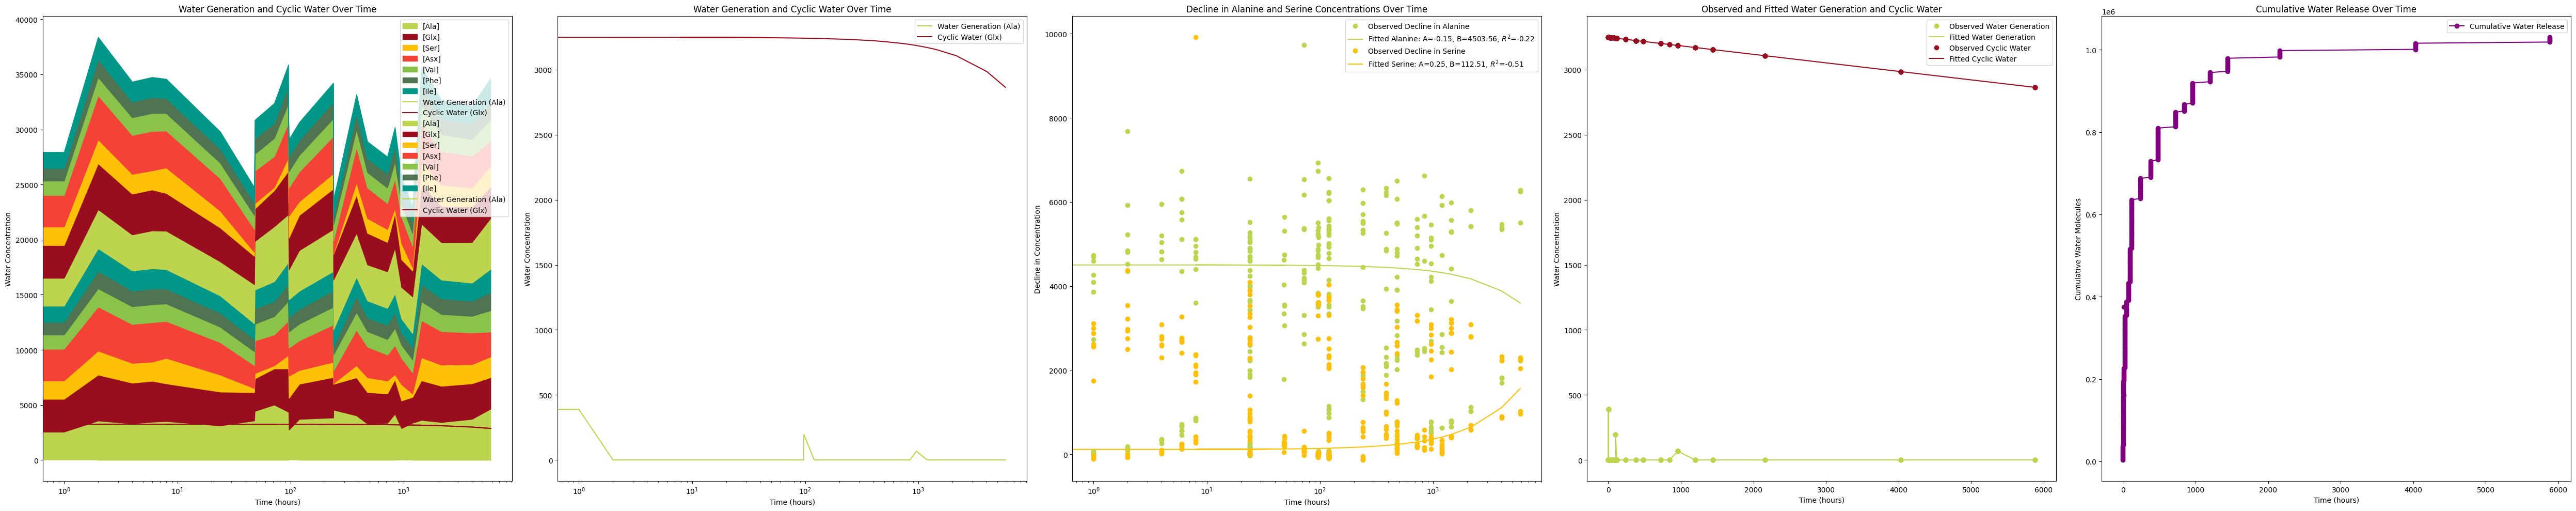

Adjusted Serine Dehydration Rate: k = 0.0002


In [7]:
#@title  Calculate water generation
# Function to categorize amino acids
def categorize_amino_acids(df):
    concentration_columns = [col for col in df.columns if col.startswith('[') and col.endswith(']')]
    categories = {
        'THAA_dehyd': ['[Ala]'],  # Alanine for dehydration
        'THAA_cyclic': ['[Glx]'],
        'THAA_serine': ['[Ser]'],  # Separate category for Serine
        'THAA_no_water': [col for col in concentration_columns if col not in ['[Ala]', '[Glx]', '[Ser]']]
    }
    return categories

# Function to initialize concentrations
def initialize_concentrations(df, categories):
    concentrations = {}

    for category, amino_acids in categories.items():
        category_dict = {}
        for aa in amino_acids:
            stats = df.groupby('time')[aa].agg(['mean', 'std']).reset_index()
            category_dict[aa] = stats
        concentrations[category] = category_dict

    return concentrations

# Calculate the mean initial concentration over the first three time points
def average_initial_concentration(data, column, num_points=3):
    return data[column].iloc[:num_points].mean()

# Calculate changes in concentration
def calculate_changes_in_concentration(data, initial_alanine, initial_serine):
    time_points = data['time'].values
    alanine_concentration = data['[Ala]'].values
    serine_concentration = data['[Ser]'].values

    change_in_alanine = alanine_concentration - initial_alanine
    change_in_serine = serine_concentration - initial_serine

    return time_points, change_in_alanine, change_in_serine

# Linear fit function for Glx and Ser
def linear_fit(t, A, B):
    return A * t + B

# Exponential decay function
def exponential_decay(t, A, k):
    return A * np.exp(-k * t)

# Fit the data to the linear model
def fit_linear_model(time_points, concentration):
    popt, pcov = curve_fit(linear_fit, time_points, concentration['mean'], sigma=concentration['std'], absolute_sigma=True)
    return popt, pcov

# Calculate R-squared for the fit
def calculate_r_squared(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Function to calculate water generation
def calculate_water_generation(concentrations, time_points, categories):
    water_generation = np.zeros(len(time_points))

    for aa in categories['THAA_dehyd']:
        initial_concentration = concentrations['THAA_dehyd'][aa]['mean'].iloc[0]
        time_values = concentrations['THAA_dehyd'][aa]['time'].values
        concentration_values = concentrations['THAA_dehyd'][aa]['mean'].values

        # Convert time_values and concentration_values to numeric, handling errors
        time_values = pd.to_numeric(time_values, errors='coerce')
        concentration_values = pd.to_numeric(concentration_values, errors='coerce')

        # Remove any NaN values introduced by conversion
        valid_indices = ~np.isnan(time_values) & ~np.isnan(concentration_values)
        time_values = time_values[valid_indices]
        concentration_values = concentration_values[valid_indices]

        concentration_values = np.interp(time_points, time_values, concentration_values)
        for i, t in enumerate(time_points):
            current_concentration = concentration_values[i]
            water_generation[i] += max(initial_concentration - current_concentration, 0)

    return water_generation

def calculate_cyclic_water(concentrations, time_points, categories):
    cyclic_water = np.zeros(len(time_points))

    for i, t in enumerate(time_points):
        for aa in categories['THAA_cyclic']:
            initial_concentration = concentrations['THAA_cyclic'][aa]['mean'].iloc[0]
            final_concentration = concentrations['THAA_cyclic'][aa]['mean'].iloc[-1]
            # Use linear fit for Glx
            cyclic_water[i] = max(initial_concentration - (initial_concentration - final_concentration) * (t / time_points[-1]), 0)

    return cyclic_water

# Main function to process data and plot results
# Main function to process data and plot results
def process_and_plot(cleaned_data, initial_length, amino_acid_colors):
    # Categorize amino acids
    categories = categorize_amino_acids(cleaned_data)

    # Initialize concentrations
    concentrations = initialize_concentrations(cleaned_data, categories)

    # Calculate initial concentrations
    initial_alanine_concentration = average_initial_concentration(cleaned_data, '[Ala]')
    initial_serine_concentration = average_initial_concentration(cleaned_data, '[Ser]')

    # Calculate changes in concentration
    time_points, change_in_alanine, change_in_serine = calculate_changes_in_concentration(
        cleaned_data, initial_alanine_concentration, initial_serine_concentration)

    # Get alanine and serine stats
    alanine_stats = cleaned_data.groupby('time')['[Ala]'].agg(['mean', 'std']).reset_index()
    serine_stats = cleaned_data.groupby('time')['[Ser]'].agg(['mean', 'std']).reset_index()

    # Fit the decline data
    valid_indices_alanine = np.isin(time_points, alanine_stats['time'])
    filtered_time_points_alanine = time_points[valid_indices_alanine]
    filtered_change_in_alanine = change_in_alanine[valid_indices_alanine]
    filtered_alanine_stats = alanine_stats[alanine_stats['time'].isin(filtered_time_points_alanine)]

    alanine_params, alanine_cov = fit_linear_model(filtered_alanine_stats['time'].values, filtered_alanine_stats)

    valid_indices_serine = np.isin(time_points, serine_stats['time'])
    filtered_time_points_serine = time_points[valid_indices_serine]
    filtered_change_in_serine = change_in_serine[valid_indices_serine]
    filtered_serine_stats = serine_stats[serine_stats['time'].isin(filtered_time_points_serine)]

    serine_params, serine_cov = fit_linear_model(filtered_serine_stats['time'].values, filtered_serine_stats)

    # Calculate R-squared
    alanine_fit = linear_fit(filtered_time_points_alanine, *alanine_params)
    serine_fit = linear_fit(filtered_time_points_serine, *serine_params)
    alanine_r_squared = calculate_r_squared(filtered_change_in_alanine, alanine_fit)
    serine_r_squared = calculate_r_squared(filtered_change_in_serine, serine_fit)

    # Print the rate estimate for serine dehydration
    serine_dehydration_rate = serine_params[0]  # Slope of the linear fit
    print(f"Serine Dehydration Rate: k = {serine_dehydration_rate:.4f}")

    # Calculate water generation and cyclic water
    water_generation = calculate_water_generation(concentrations, time_points, categories)
    cyclic_water = calculate_cyclic_water(concentrations, time_points, categories)

    # Calculate cumulative water release
    cumulative_water_release = np.cumsum(water_generation + cyclic_water)

    # Plot results
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(50, 10))

    # Existing plots for amino acid concentrations and water generation
    unique_times = cleaned_data['time'].unique()
    bottom = np.zeros(len(unique_times))

    for category in concentrations.values():
        for aa, stats in category.items():
            concentration = pd.to_numeric(stats['mean'].values, errors='coerce')
            valid_indices = ~np.isnan(concentration)
            concentration = concentration[valid_indices]
            color = amino_acid_colors_conc.get(aa, 'gray')
            ax1.fill_between(unique_times[valid_indices], bottom[valid_indices], bottom[valid_indices] + concentration, label=aa, color=color)
            bottom[valid_indices] += concentration

    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Concentration')
    ax1.set_title('Amino Acid Concentrations Over Time')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

   # Line plots for water generation and cyclic water
    ala_color = amino_acid_colors_conc.get('[Ala]', 'blue')
    ser_color = amino_acid_colors_conc.get('[Ser]', 'green')
    glx_color = amino_acid_colors_conc.get('[Glx]', 'red')

    ax1.semilogx(time_points, water_generation, label='Water Generation (Ala)', color=ala_color)
    ax1.semilogx(time_points, cyclic_water, label='Cyclic Water (Glx)', color=glx_color)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Water Concentration')
    ax1.set_title('Water Generation and Cyclic Water Over Time')
    ax1.legend()

    ax2.semilogx(time_points, water_generation, label='Water Generation (Ala)', color=ala_color)
    ax2.semilogx(time_points, cyclic_water, label='Cyclic Water (Glx)', color=glx_color)
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Water Concentration')
    ax2.set_title('Water Generation and Cyclic Water Over Time')
    ax2.legend()

    for category in concentrations.values():
        for aa, stats in category.items():
            concentration = pd.to_numeric(stats['mean'].values, errors='coerce')
            valid_indices = ~np.isnan(concentration)
            concentration = concentration[valid_indices]
            color = amino_acid_colors_conc.get(aa, 'gray')
            ax1.fill_between(unique_times[valid_indices], bottom[valid_indices], bottom[valid_indices] + concentration, label=aa, color=color)
            bottom[valid_indices] += concentration

    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Concentration')
    ax1.set_title('Amino Acid Concentrations Over Time')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

   # Line plots for water generation and cyclic water
    ala_color = amino_acid_colors_conc.get('[Ala]', 'blue')
    ser_color = amino_acid_colors_conc.get('[Ser]', 'green')
    glx_color = amino_acid_colors_conc.get('[Glx]', 'red')

    ax1.semilogx(time_points, water_generation, label='Water Generation (Ala)', color=ala_color)
    ax1.semilogx(time_points, cyclic_water, label='Cyclic Water (Glx)', color=glx_color)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Water Concentration')
    ax1.set_title('Water Generation and Cyclic Water Over Time')
    ax1.legend()

    # New plot for decline in alanine and serine concentrations
    ax3.semilogx(filtered_time_points_alanine, filtered_change_in_alanine, 'o', label='Observed Decline in Alanine', color=ala_color)
    ax3.semilogx(filtered_time_points_alanine, alanine_fit, '-', label=f'Fitted Alanine: A={alanine_params[0]:.2f}, B={alanine_params[1]:.2f}, $R^2$={alanine_r_squared:.2f}', color=ala_color)
    ax3.semilogx(filtered_time_points_serine, filtered_change_in_serine, 'o', label='Observed Decline in Serine', color=ser_color)
    ax3.semilogx(filtered_time_points_serine, serine_fit, '-', label=f'Fitted Serine: A={serine_params[0]:.2f}, B={serine_params[1]:.2f}, $R^2$={serine_r_squared:.2f}', color=ser_color)
    ax3.set_xlabel('Time (hours)')
    ax3.set_ylabel('Decline in Concentration')
    ax3.set_title('Decline in Alanine and Serine Concentrations Over Time')
    ax3.legend()

    # Plot for observed and fitted water generation and cyclic water
    ax4.plot(time_points, water_generation, 'o', label='Observed Water Generation', color=ala_color)
    ax4.plot(time_points, water_generation, '-', label='Fitted Water Generation', color=ala_color)
    ax4.plot(time_points, cyclic_water, 'o', label='Observed Cyclic Water', color=glx_color)
    ax4.plot(time_points, cyclic_water, '-', label='Fitted Cyclic Water', color=glx_color)
    ax4.set_xlabel('Time (hours)')
    ax4.set_ylabel('Water Concentration')
    ax4.set_title('Observed and Fitted Water Generation and Cyclic Water')
    ax4.legend()

    # Plot for cumulative water release
    ax5.plot(time_points, cumulative_water_release, 'o-', label='Cumulative Water Release', color='purple')
    ax5.set_xlabel('Time (hours)')
    ax5.set_ylabel('Cumulative Water Molecules')
    ax5.set_title('Cumulative Water Release Over Time')
    ax5.legend()

    plt.tight_layout()
    plt.show()

    return serine_dehydration_rate

# Function to adjust the rate based on polymer length
def adjusted_rate_for_polymer_length(rate, initial_length):
    # Example adjustment: rate is inversely proportional to polymer length
    return rate / initial_length

# Function to adjust the rate based on polymer length
def adjusted_rate_for_polymer_length(rate, initial_length):
    # Example adjustment: rate is inversely proportional to polymer length
    return rate / initial_length

# Example usage
# Assuming cleaned_data and initial_length are defined
# cleaned_data = pd.read_csv('your_data.csv')  # Or however you load your data
# initial_length = 100  # Example initial length
serine_dehydration_rate = process_and_plot(cleaned_data, initial_length, amino_acid_colors)
serine_dehydration_rate_adjusted = adjusted_rate_for_polymer_length(serine_dehydration_rate, initial_length)
print(f"Adjusted Serine Dehydration Rate: k = {serine_dehydration_rate_adjusted:.4f}")


In [8]:
#@title 2nd Order model


def second_order_hydrolysis(peptide_conc, water_conc, rate_constant, dt):
    """
    Calculate the amount of hydrolysis based on second-order reaction kinetics.
    """
    effective_rate = rate_constant * water_conc * dt
    hydrolysis = peptide_conc * effective_rate / (1 + effective_rate)
    return hydrolysis



def rescale_rates(rate_params, current_unit, desired_unit):
    """Rescale rate parameters to the desired time unit.

    Args:
        rate_params (dict): Original rate parameters.
        current_unit (str): Current time unit of the rates ('sec', 'hour', 'day', 'year').
        desired_unit (str): Desired time unit for the rates ('sec', 'hour', 'day', 'year').

    Returns:
        dict: Rescaled rate parameters.
    """
    # Time unit conversion factors
    time_units_in_seconds = {
        'sec': 1,
        'hour': 3600,
        'day': 86400,
        'week': 604800,  # 7 days
        'month': 2628000,  # 30.44 days on average
        'year': 31536000  # 365 days
    }

    if current_unit not in time_units_in_seconds or desired_unit not in time_units_in_seconds:
        raise ValueError("Invalid time unit. Choose from 'sec', 'hour', 'day', 'year'.")

    # Calculate the scaling factor
    scale_factor = time_units_in_seconds[desired_unit] / time_units_in_seconds[current_unit]

    # Rescale the rates
    rescaled_rates = {key: value * scale_factor for key, value in rate_params.items()}

    return rescaled_rates


# def simulate_step(state, rates):
#     """Simulate one time step of hydrolysis, racemization, and loss."""
#     new_state = state.copy()


#     # Hydrolysis (using second-order kinetics)
#     for source, target in [('int', 'term'), ('term', 'free')]:
#         total_peptides = state[f'L_{source}'] + state[f'D_{source}']
#         if total_peptides > 0 and state['water'] > 0:
#             # Adjust hydrolysis rate based on water concentration
#             water_conc = state['water'] / (N * fold_water)
#             effective_rate = rates[f'k_{source}'] * water_conc
#             hydrolyzed = np.random.binomial(total_peptides, effective_rate)
#             for chirality in ['L', 'D']:
#                 moved = int(hydrolyzed * (state[f'{chirality}_{source}'] / total_peptides))
#                 new_state[f'{chirality}_{source}'] -= moved
#                 new_state[f'{chirality}_{target}'] += moved
#             # Consume water molecules
#             new_state['water'] -= hydrolyzed

#     # Racemization
#     for location in ['int', 'term', 'free']:
#         rate = rates[f'slow_DL_{location}_pool_relative_rate']
#         for source, target in [('L', 'D'), ('D', 'L')]:
#             racemized = np.random.binomial(state[f'{source}_{location}'], rate)
#             new_state[f'{source}_{location}'] -= racemized
#             new_state[f'{target}_{location}'] += racemized

#     # Loss of free amino acids
#     for chirality in ['L', 'D']:
#         lost = np.random.binomial(state[f'{chirality}_free'], rates['k_loss'])
#         new_state[f'{chirality}_free'] -= lost

#     return new_state

def simulate_step(state, rates):
    """Simulate one time step of hydrolysis, racemization, and loss."""
    new_state = state.copy()

    # 2nd order Hydrolysis
    for source, target in [('int', 'term'), ('term', 'free')]:
        total = state[f'L_{source}'] + state[f'D_{source}']
        if total > 0 and state['water'] > 0:
            # Adjust hydrolysis rate based on water concentration
            effective_rate = rates[f'k_{source}'] * (state['water'] / (N * fold_water))
            hydrolyzed = np.random.binomial(total, effective_rate)
            for chirality in ['L', 'D']:
                moved = int(hydrolyzed * (state[f'{chirality}_{source}'] / total))
                new_state[f'{chirality}_{source}'] -= moved
                new_state[f'{chirality}_{target}'] += moved
            # Consume water molecules
            new_state['water'] -= hydrolyzed

    # Racemization
    for location in ['int', 'term', 'free']:
        rate = rates[f'racemization_rate_{location}']
        for source, target in [('L', 'D'), ('D', 'L')]:
            racemized = np.random.binomial(state[f'{source}_{location}'], rate)
            new_state[f'{source}_{location}'] -= racemized
            new_state[f'{target}_{location}'] += racemized

    # Loss of free amino acids
    for chirality in ['L', 'D']:
        lost = np.random.binomial(state[f'{chirality}_free'], rates['k_loss'])
        new_state[f'{chirality}_free'] -= lost

    # Extra reaction for free amino acids
    for chirality in ['L', 'D']:
        extra_reacted = np.random.binomial(state[f'{chirality}_free'], rates['k_free'])
        new_state[f'{chirality}_free'] -= extra_reacted

    return new_state

def run_simulation(initial_state, rates, time_steps):
    """
    Run the full simulation.
    """
    results = {key: [value] for key, value in initial_state.items()}
    results['time'] = [0]

    state = initial_state
    for t in range(1, time_steps + 1):
        state = simulate_step(state, rates)
        for key, value in state.items():
            results[key].append(value)
        results['time'].append(t)

    return results

def calculate_ratios(results):
    """
    Calculate D/L ratios for each amino acid state and overall.
    """
    ratios = {}
    for location in ['int', 'term', 'free']:
        L = np.array(results[f'L_{location}'])
        D = np.array(results[f'D_{location}'])
        ratios[f'{location}_D_L_ratio'] = np.divide(D, L, where=L != 0)

    # Calculate overall D/L ratio
    total_L = np.array(results['L_int']) + np.array(results['L_term']) + np.array(results['L_free'])
    total_D = np.array(results['D_int']) + np.array(results['D_term']) + np.array(results['D_free'])
    ratios['overall_D_L_ratio'] = np.divide(total_D, total_L, where=total_L != 0)

    return ratios

def plot_results(results, ratios):
    """
    Plot the simulation results.
    """
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    locations = ['int', 'term', 'free']
    titles = ['Internal Amino Acids', 'Terminal Amino Acids', 'Free Amino Acids']

    for i, (location, title) in enumerate(zip(locations, titles)):
        ax = axs[0, i]
        ax.plot(results['time'], results[f'L_{location}'], label=f'{location.capitalize()} L')
        ax.plot(results['time'], results[f'D_{location}'], label=f'{location.capitalize()} D')
        ax.set_xlabel('Time')
        ax.set_ylabel('Number of Amino Acids')
        ax.set_title(title)
        ax.legend()

    ax = axs[1, 0]
    for location in locations:
        ax.plot(results['time'], ratios[f'{location}_D_L_ratio'], label=f'{location.capitalize()} D/L Ratio')
    ax.plot(results['time'], ratios['overall_D_L_ratio'], label='Overall D/L Ratio', linewidth=2, color='black')
    ax.set_xlabel('Time')
    ax.set_ylabel('D/L Ratio')
    ax.set_title('D/L Ratios')
    ax.legend()

    ax = axs[1, 1]
    ax.plot(results['time'], results['water'], label='Water Molecules')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Water Molecules')
    ax.set_title('Water Consumption')
    ax.legend()

    ax = axs[1, 2]
    total_amino_acids = np.sum([np.array(results[f'{chirality}_{location}'])
                                for chirality in ['L', 'D']
                                for location in locations], axis=0)
    ax.plot(results['time'], total_amino_acids, label='Total Amino Acids')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Total Amino Acids')
    ax.legend()

    plt.tight_layout()
    plt.show()




2nd order model v2

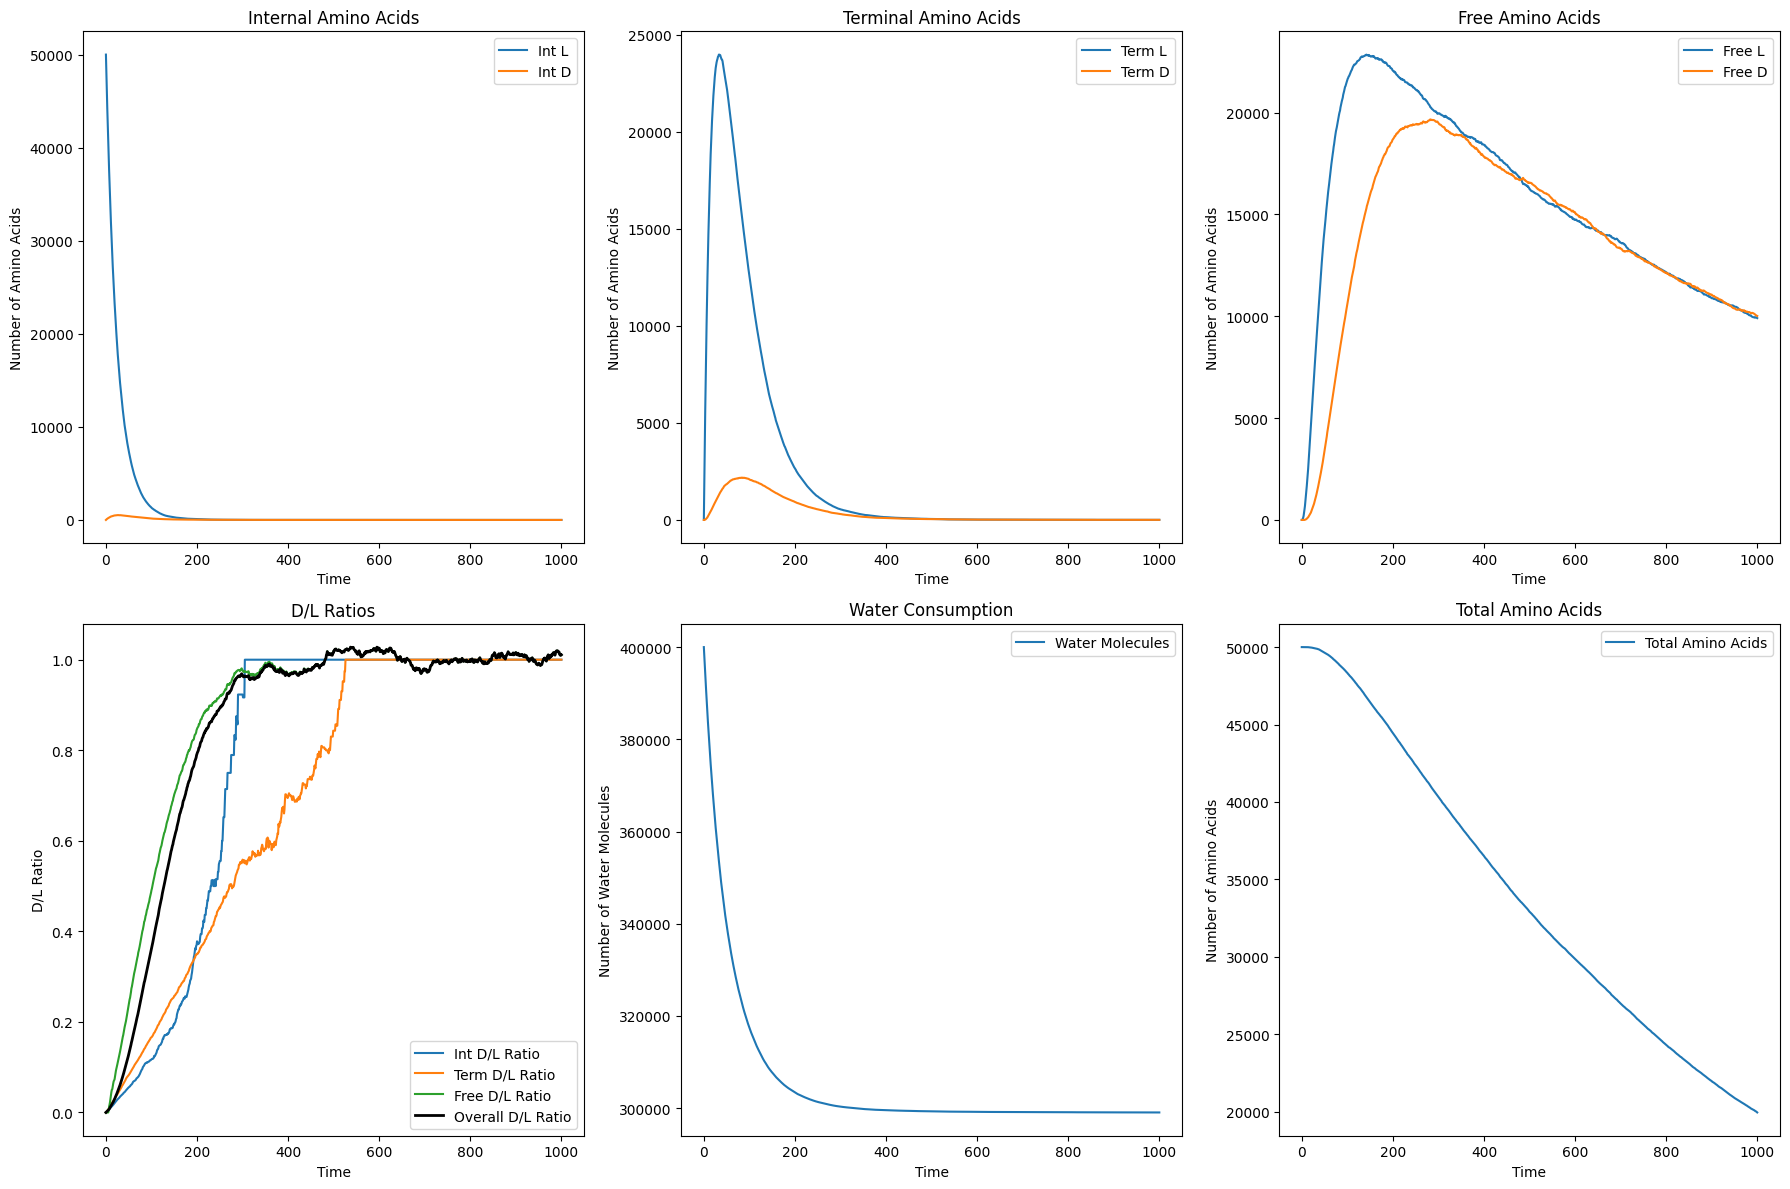

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 50000  # Initial number of amino acids
fold_water = 8  # Initial water concentration relative to amino acids
k_internal = 0.04  # Rate constant for internal to terminal hydrolysis
k_terminal = 0.02  # Rate constant for terminal to free hydrolysis
k_loss = 0.001  # Rate of free amino acid loss
racemization_rate_polymer = 0.001  # Racemization rate for internal amino acids
racemization_rate_terminal = 0.002  # Racemization rate for terminal amino acids
racemization_rate_free = 0.01  # Racemization rate for free amino acids
time_steps = 1000  # Number of time steps for the simulation
dt = 1  # Time step size

# Initial conditions
initial_state = {
    'L_int': N,
    'D_int': 0,
    'L_term': 0,
    'D_term': 0,
    'L_free': 0,
    'D_free': 0,
    'water': N * fold_water  # Initial water molecules
}

def simulate_step(state, rates):
    """Simulate one time step of hydrolysis, racemization, and loss."""
    new_state = state.copy()

    # 2nd order Hydrolysis
    for source, target in [('int', 'term'), ('term', 'free')]:
        total = state[f'L_{source}'] + state[f'D_{source}']
        if total > 1 and state['water'] > 0:  # Stop hydrolysis if total is 1 or less
            # Adjust hydrolysis rate based on water concentration
            effective_rate = rates[f'k_{source}'] * (state['water'] / (N * fold_water))
            hydrolyzed = np.random.binomial(total, effective_rate)
            for chirality in ['L', 'D']:
                moved = int(hydrolyzed * (state[f'{chirality}_{source}'] / total))
                new_state[f'{chirality}_{source}'] -= moved
                new_state[f'{chirality}_{target}'] += moved
            # Consume water molecules
            new_state['water'] -= hydrolyzed

    # Racemization
    for location in ['int', 'term', 'free']:
        if state[f'L_{location}'] + state[f'D_{location}'] > N * 0.005:  # Stop racemization if total is less than 0.05%
            rate = rates[f'racemization_rate_{location}']
            for source, target in [('L', 'D'), ('D', 'L')]:
                racemized = np.random.binomial(state[f'{source}_{location}'], rate)
                new_state[f'{source}_{location}'] -= racemized
                new_state[f'{target}_{location}'] += racemized

    # Loss of free amino acids
    for chirality in ['L', 'D']:
        lost = np.random.binomial(state[f'{chirality}_free'], rates['k_loss'])
        new_state[f'{chirality}_free'] -= lost

    return new_state

def run_simulation(initial_state, rates, time_steps):
    """Run the full simulation."""
    results = {key: [value] for key, value in initial_state.items()}
    results['time'] = [0]

    state = initial_state
    for t in range(1, time_steps + 1):
        state = simulate_step(state, rates)
        for key, value in state.items():
            results[key].append(value)
        results['time'].append(t)

    return results

def calculate_ratios(results):
    """Calculate D/L ratios for each amino acid state and overall."""
    ratios = {}
    for location in ['int', 'term', 'free']:
        L = np.array(results[f'L_{location}'])
        D = np.array(results[f'D_{location}'])
        ratios[f'{location}_D_L_ratio'] = np.divide(D, L, where=L != 0)

    # Calculate overall D/L ratio
    total_L = np.array(results['L_int']) + np.array(results['L_term']) + np.array(results['L_free'])
    total_D = np.array(results['D_int']) + np.array(results['D_term']) + np.array(results['D_free'])
    ratios['overall_D_L_ratio'] = np.divide(total_D, total_L, where=total_L != 0)

    return ratios

def plot_results(results, ratios):
    """Plot the simulation results."""
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    locations = ['int', 'term', 'free']
    titles = ['Internal Amino Acids', 'Terminal Amino Acids', 'Free Amino Acids']

    for i, (location, title) in enumerate(zip(locations, titles)):
        ax = axs[0, i]
        ax.plot(results['time'], results[f'L_{location}'], label=f'{location.capitalize()} L')
        ax.plot(results['time'], results[f'D_{location}'], label=f'{location.capitalize()} D')
        ax.set_xlabel('Time')
        ax.set_ylabel('Number of Amino Acids')
        ax.set_title(title)
        ax.legend()

    ax = axs[1, 0]
    for location in locations:
        ax.plot(results['time'], ratios[f'{location}_D_L_ratio'], label=f'{location.capitalize()} D/L Ratio')
    ax.plot(results['time'], ratios['overall_D_L_ratio'], label='Overall D/L Ratio', linewidth=2, color='black')
    ax.set_xlabel('Time')
    ax.set_ylabel('D/L Ratio')
    ax.set_title('D/L Ratios')
    ax.legend()

    ax = axs[1, 1]
    ax.plot(results['time'], results['water'], label='Water Molecules')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Water Molecules')
    ax.set_title('Water Consumption')
    ax.legend()

    ax = axs[1, 2]
    total_amino_acids = np.sum([np.array(results[f'{chirality}_{location}'])
                                for chirality in ['L', 'D']
                                for location in locations], axis=0)
    ax.plot(results['time'], total_amino_acids, label='Total Amino Acids')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Total Amino Acids')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Run simulation
rates = {
    'k_int': k_internal * dt,
    'k_term': k_terminal * dt,
    'k_loss': k_loss * dt,
    'racemization_rate_int': racemization_rate_polymer * dt,
    'racemization_rate_term': racemization_rate_terminal * dt,
    'racemization_rate_free': racemization_rate_free * dt
}

results = run_simulation(initial_state, rates, time_steps)
ratios = calculate_ratios(results)
plot_results(results, ratios)


Now with  a slow fraction

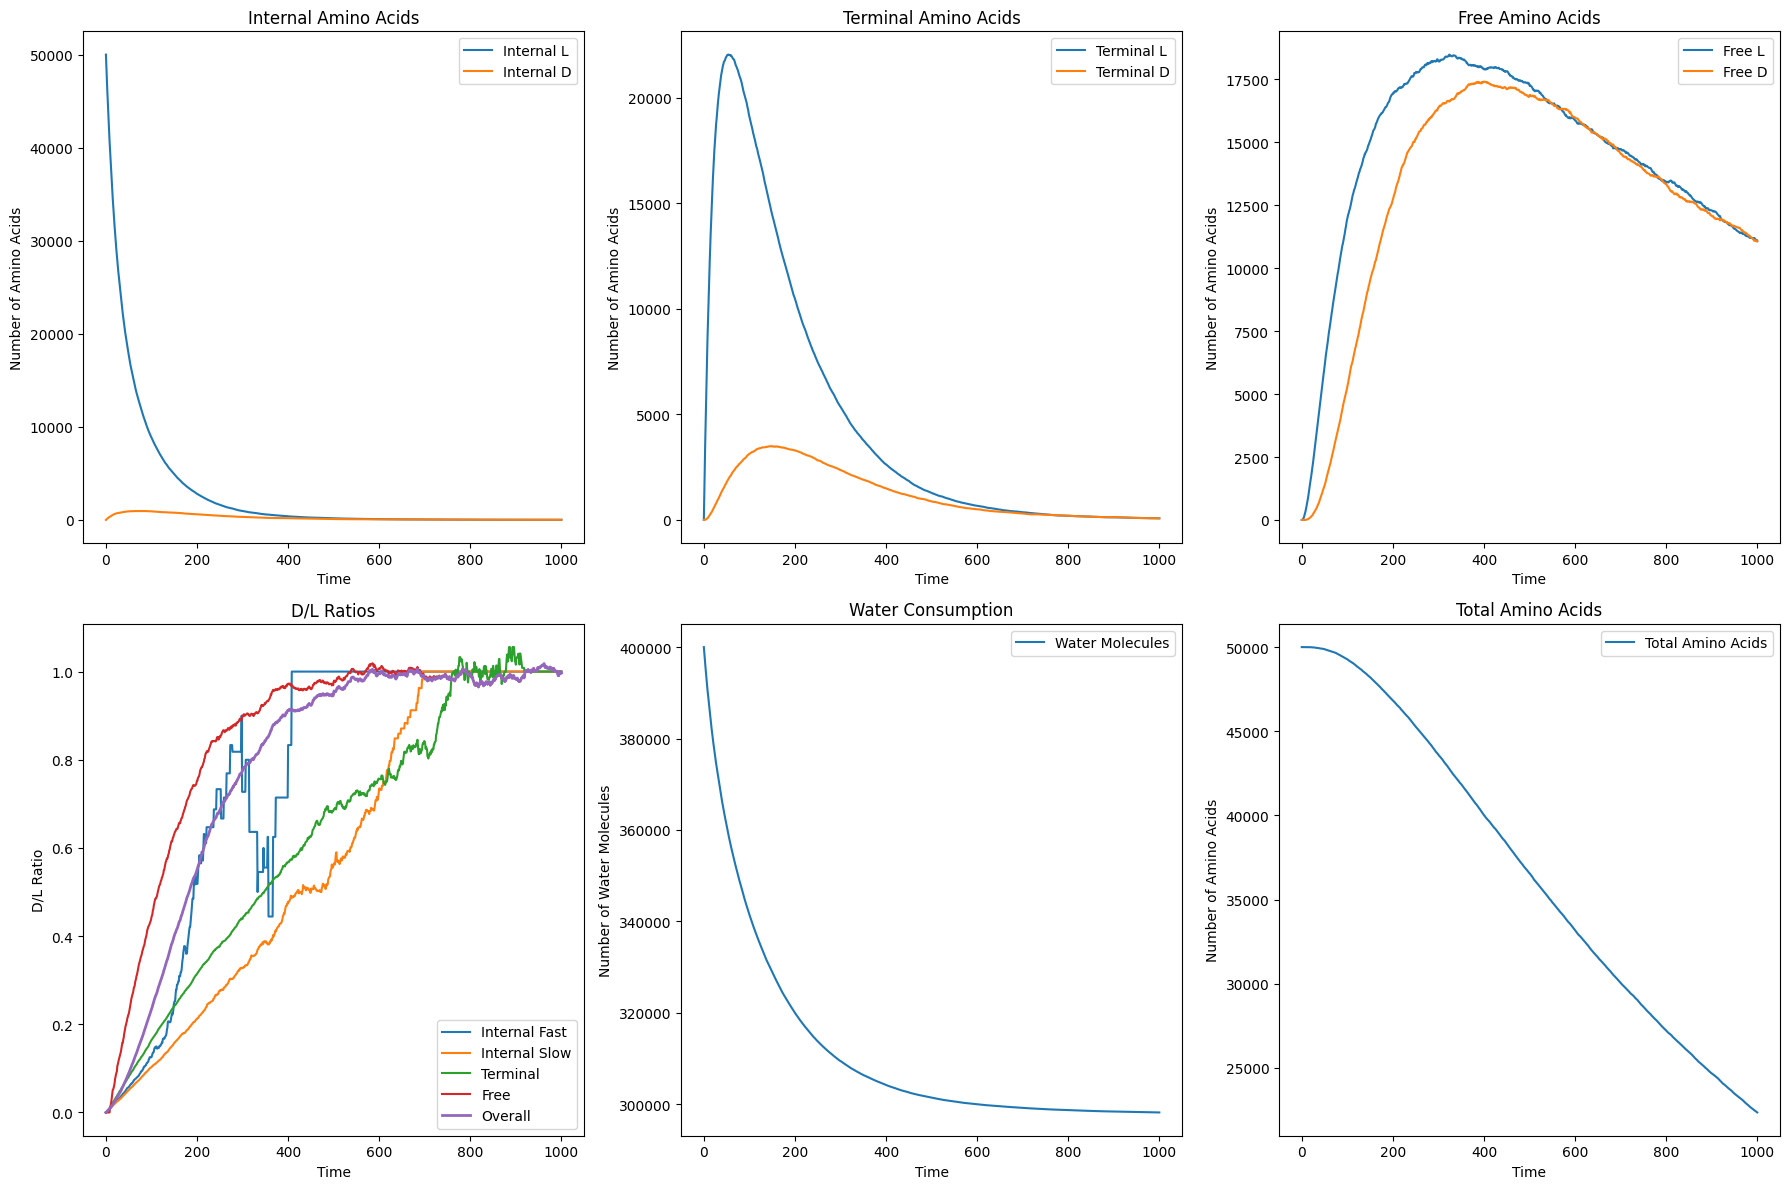

In [26]:
import numpy as np

# Parameters
N = 50000  # Initial number of amino acids
fold_water = 8  # Initial water concentration relative to amino acids
k_internal = 0.04  # Rate constant for internal to terminal hydrolysis
k_terminal = 0.01  # Rate constant for terminal to free hydrolysis
k_loss = 0.001  # Rate of free amino acid loss
racemization_rate_polymer = 0.001  # Racemization rate for internal amino acids
racemization_rate_terminal = 0.002  # Racemization rate for terminal amino acids
racemization_rate_free = 0.01  # Racemization rate for free amino acids
time_steps = 1000  # Number of time steps for the simulation
dt = 1  # Time step size

# New parameters for slow fractions
slow_internal_hydrolysis_fraction = 0.5
slow_internal_hydrolysis_rate = 0.01
slow_racemization_rate_polymer_fraction = 0.5
slow_racemization_rate_polymer_rate = 0.001

# Initial conditions
initial_state = {
    'L_int_fast': int(N * (1 - slow_internal_hydrolysis_fraction)),
    'L_int_slow': int(N * slow_internal_hydrolysis_fraction),
    'D_int_fast': 0,
    'D_int_slow': 0,
    'L_term': 0,
    'D_term': 0,
    'L_free': 0,
    'D_free': 0,
    'water': N * fold_water  # Initial water molecules
}

def simulate_step(state, rates):
    """Simulate one time step of hydrolysis, racemization, and loss."""
    new_state = state.copy()

    # 2nd order Hydrolysis
    for source, target in [('int', 'term'), ('term', 'free')]:
        if source == 'int':
            total_fast = state[f'L_{source}_fast'] + state[f'D_{source}_fast']
            total_slow = state[f'L_{source}_slow'] + state[f'D_{source}_slow']
            total = total_fast + total_slow
        else:
            total = state[f'L_{source}'] + state[f'D_{source}']

        if total > 1 and state['water'] > 0:  # Stop hydrolysis if total is 1 or less
            # Adjust hydrolysis rate based on water concentration
            effective_rate = rates[f'k_{source}'] * (state['water'] / (N * fold_water))

            if source == 'int':
                # Fast fraction hydrolysis
                hydrolyzed_fast = np.random.binomial(total_fast, effective_rate)
                # Slow fraction hydrolysis
                hydrolyzed_slow = np.random.binomial(total_slow, slow_internal_hydrolysis_rate)
                total_hydrolyzed = hydrolyzed_fast + hydrolyzed_slow
            else:
                # Regular hydrolysis for terminal
                total_hydrolyzed = np.random.binomial(total, effective_rate)

            for chirality in ['L', 'D']:
                if source == 'int':
                    moved_fast = int(hydrolyzed_fast * (state[f'{chirality}_{source}_fast'] / total_fast))
                    moved_slow = int(hydrolyzed_slow * (state[f'{chirality}_{source}_slow'] / total_slow))
                    new_state[f'{chirality}_{source}_fast'] -= moved_fast
                    new_state[f'{chirality}_{source}_slow'] -= moved_slow
                    new_state[f'{chirality}_{target}'] += moved_fast + moved_slow
                else:
                    moved = int(total_hydrolyzed * (state[f'{chirality}_{source}'] / total))
                    new_state[f'{chirality}_{source}'] -= moved
                    new_state[f'{chirality}_{target}'] += moved

            # Consume water molecules
            new_state['water'] -= total_hydrolyzed

    # Racemization
    for location in ['int', 'term', 'free']:
        if location == 'int':
            total_fast = state[f'L_{location}_fast'] + state[f'D_{location}_fast']
            total_slow = state[f'L_{location}_slow'] + state[f'D_{location}_slow']
            total = total_fast + total_slow
        else:
            total = state[f'L_{location}'] + state[f'D_{location}']

        if total > N * 0.005:  # Stop racemization if total is less than 0.05%
            rate = rates[f'racemization_rate_{location}']

            for source, target in [('L', 'D'), ('D', 'L')]:
                if location == 'int':
                    # Fast fraction racemization
                    racemized_fast = np.random.binomial(state[f'{source}_{location}_fast'], rate)
                    # Slow fraction racemization
                    racemized_slow = np.random.binomial(state[f'{source}_{location}_slow'], slow_racemization_rate_polymer_rate)

                    new_state[f'{source}_{location}_fast'] -= racemized_fast
                    new_state[f'{target}_{location}_fast'] += racemized_fast
                    new_state[f'{source}_{location}_slow'] -= racemized_slow
                    new_state[f'{target}_{location}_slow'] += racemized_slow
                else:
                    racemized = np.random.binomial(state[f'{source}_{location}'], rate)
                    new_state[f'{source}_{location}'] -= racemized
                    new_state[f'{target}_{location}'] += racemized

    # Loss of free amino acids
    for chirality in ['L', 'D']:
        lost = np.random.binomial(state[f'{chirality}_free'], rates['k_loss'])
        new_state[f'{chirality}_free'] -= lost

    return new_state

# def simulate_step(state, rates, initial_total):
#     new_state = state.copy()

#     # Calculate current totals for each location
#     totals = {
#         'int': (state['L_int_fast'] + state['D_int_fast'] +
#                 state['L_int_slow'] + state['D_int_slow']),
#         'term': state['L_term'] + state['D_term'],
#         'free': state['L_free'] + state['D_free']
#     }

#     # 2nd order Hydrolysis
#     for source, target in [('int', 'term'), ('term', 'free')]:
#         if totals[source] > initial_total * 0.01 and state['water'] > 0:
#             # Adjust hydrolysis rate based on water concentration
#             effective_rate = rates[f'k_{source}'] * (state['water'] / (initial_total * fold_water))

#             if source == 'int':
#                 total_fast = state['L_int_fast'] + state['D_int_fast']
#                 total_slow = state['L_int_slow'] + state['D_int_slow']

#                 # Fast fraction hydrolysis
#                 hydrolyzed_fast = np.random.binomial(total_fast, effective_rate)
#                 # Slow fraction hydrolysis
#                 hydrolyzed_slow = np.random.binomial(total_slow, slow_internal_hydrolysis_rate)
#                 total_hydrolyzed = hydrolyzed_fast + hydrolyzed_slow

#                 for chirality in ['L', 'D']:
#                     if total_fast > 0:
#                         moved_fast = int(hydrolyzed_fast * (state[f'{chirality}_int_fast'] / total_fast))
#                         new_state[f'{chirality}_int_fast'] -= moved_fast
#                         new_state[f'{chirality}_term'] += moved_fast
#                     if total_slow > 0:
#                         moved_slow = int(hydrolyzed_slow * (state[f'{chirality}_int_slow'] / total_slow))
#                         new_state[f'{chirality}_int_slow'] -= moved_slow
#                         new_state[f'{chirality}_term'] += moved_slow
#             else:
#                 total = state[f'L_{source}'] + state[f'D_{source}']
#                 total_hydrolyzed = np.random.binomial(total, effective_rate)

#                 for chirality in ['L', 'D']:
#                     moved = int(total_hydrolyzed * (state[f'{chirality}_{source}'] / total))
#                     new_state[f'{chirality}_{source}'] -= moved
#                     new_state[f'{chirality}_{target}'] += moved

#             # Consume water molecules
#             new_state['water'] -= total_hydrolyzed

#     # Racemization
#     for location in ['int', 'term', 'free']:
#         if totals[location] > initial_total * 0.000:  # stope reaction when it falls to
#             rate = rates[f'racemization_rate_{location}']

#             if location == 'int':
#                 for suffix in ['fast', 'slow']:
#                     for source, target in [('L', 'D'), ('D', 'L')]:
#                         racemization_rate = rate if suffix == 'fast' else slow_racemization_rate_polymer_rate
#                         racemized = np.random.binomial(state[f'{source}_{location}_{suffix}'], racemization_rate)
#                         new_state[f'{source}_{location}_{suffix}'] -= racemized
#                         new_state[f'{target}_{location}_{suffix}'] += racemized
#             else:
#                 for source, target in [('L', 'D'), ('D', 'L')]:
#                     racemized = np.random.binomial(state[f'{source}_{location}'], rate)
#                     new_state[f'{source}_{location}'] -= racemized
#                     new_state[f'{target}_{location}'] += racemized

#     # Loss of free amino acids
#     if totals['free'] > initial_total * 0.005:
#         for chirality in ['L', 'D']:
#             lost = np.random.binomial(state[f'{chirality}_free'], rates['k_loss'])
#             new_state[f'{chirality}_free'] -= lost

#     return new_state

def run_simulation(initial_state, rates, time_steps):
    """Run the full simulation."""
    results = {key: [value] for key, value in initial_state.items()}
    results['time'] = [0]

    state = initial_state
    for t in range(1, time_steps + 1):
        state = simulate_step(state, rates)
        for key, value in state.items():
            results[key].append(value)
        results['time'].append(t)
    return results

# def run_simulation(initial_state, rates, time_steps):
#     results = {key: [value] for key, value in initial_state.items()}
#     results['time'] = [0]

#     state = initial_state
#     initial_total = sum(initial_state.values()) - initial_state['water']

#     for t in range(1, time_steps + 1):
#         state = simulate_step(state, rates, initial_total)
#         for key, value in state.items():
#             results[key].append(value)
#         results['time'].append(t)

    return results

def calculate_ratios(results):
    """Calculate D/L ratios for each amino acid state and overall."""
    ratios = {}
    for location in ['int_fast', 'int_slow', 'term', 'free']:
        L = np.array(results[f'L_{location}'])
        D = np.array(results[f'D_{location}'])
        ratios[f'{location}_D_L_ratio'] = np.divide(D, L, where=L != 0)

    # Calculate overall D/L ratio
    total_L = (np.array(results['L_int_fast']) + np.array(results['L_int_slow']) +
               np.array(results['L_term']) + np.array(results['L_free']))
    total_D = (np.array(results['D_int_fast']) + np.array(results['D_int_slow']) +
               np.array(results['D_term']) + np.array(results['D_free']))
    ratios['overall_D_L_ratio'] = np.divide(total_D, total_L, where=total_L != 0)

    return ratios

# Define rates
rates = {
    'k_int': k_internal,
    'k_term': k_terminal,
    'k_loss': k_loss,
    'racemization_rate_int': racemization_rate_polymer,
    'racemization_rate_term': racemization_rate_terminal,
    'racemization_rate_free': racemization_rate_free
}


def plot_results(results, ratios):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    # Plot internal amino acids (combining fast and slow fractions)
    ax = axs[0, 0]
    ax.plot(results['time'], np.array(results['L_int_fast']) + np.array(results['L_int_slow']), label='Internal L')
    ax.plot(results['time'], np.array(results['D_int_fast']) + np.array(results['D_int_slow']), label='Internal D')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Internal Amino Acids')
    ax.legend()

    # Plot terminal amino acids
    ax = axs[0, 1]
    ax.plot(results['time'], results['L_term'], label='Terminal L')
    ax.plot(results['time'], results['D_term'], label='Terminal D')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Terminal Amino Acids')
    ax.legend()

    # Plot free amino acids
    ax = axs[0, 2]
    ax.plot(results['time'], results['L_free'], label='Free L')
    ax.plot(results['time'], results['D_free'], label='Free D')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Free Amino Acids')
    ax.legend()

    # Plot D/L ratios
    ax = axs[1, 0]
    ax.plot(results['time'], ratios['int_fast_D_L_ratio'], label='Internal Fast')
    ax.plot(results['time'], ratios['int_slow_D_L_ratio'], label='Internal Slow')
    ax.plot(results['time'], ratios['term_D_L_ratio'], label='Terminal')
    ax.plot(results['time'], ratios['free_D_L_ratio'], label='Free')
    ax.plot(results['time'], ratios['overall_D_L_ratio'], label='Overall', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_ylabel('D/L Ratio')
    ax.set_title('D/L Ratios')
    ax.legend()

    # Plot water consumption
    ax = axs[1, 1]
    ax.plot(results['time'], results['water'], label='Water Molecules')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Water Molecules')
    ax.set_title('Water Consumption')
    ax.legend()

    # Plot total amino acids
    ax = axs[1, 2]
    total_amino_acids = (np.array(results['L_int_fast']) + np.array(results['D_int_fast']) +
                         np.array(results['L_int_slow']) + np.array(results['D_int_slow']) +
                         np.array(results['L_term']) + np.array(results['D_term']) +
                         np.array(results['L_free']) + np.array(results['D_free']))
    ax.plot(results['time'], total_amino_acids, label='Total Amino Acids')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Total Amino Acids')
    ax.legend()

    plt.tight_layout()
    plt.show()

# Run simulation
results = run_simulation(initial_state, rates, time_steps)
ratios = calculate_ratios(results)
plot_results(results, ratios)
# Now you can plot the results and ratios

In [ ]:
#@title #model parameters

# #NUM_TIME_POINTS = 10  # This is set earlier as is need to map the water dehydration data
# #protein
# initial_length = 1500  # Example initial protein length#@title  Function to simulate
# fold_water = 8

# user_defined_max_time = 1200  # Example of user-defined max_time


# Parameters

N = 50000  # Initial number of amino acids
fold_water = 8  # Initial water concentration relative to amino acids
temperature_kelvin = 353.15
NUM_TIME_POINTS = 1000  # Example value; adjust as necessary
dt = 1
amino_acid = 'Asx'
user_defined_max_time = 1500  # Example of user-defined max_time
real_DL = 1  # Placeholder for real_DL, set to an example value
initial_state = {
    'L_int': initial_length,
    'D_int': 0,
    'L_term': 0,
    'D_term': 0,
    'L_free': 0,
    'D_free': 0,
    'water': initial_length * fold_water  # Initial water molecules
}

# rate_params = {
#     'fixed_rate_hydrolysis': 0.4,
#     'fixed_rate_loss': 0.2466,  # starting rate taken for Serine decomposition - from the water dehydration step
#     'fixed_rate_int': 0.0,  # fixed_rate_internal
#     'fixed_rate_term': 0.05,  # fixed_rate_terminal
#     'fixed_rate_free': 0.005,  # fixed_rate_free
#     'slow_hydrolysis_pool_size': 0.5,  # slow_hydrolysis_pool_size:
#     'slow_hydrolysis_pool_relative_rate': 0.00013,  # slow_hydrolysis_pool_relative_rate:
#     'slow_DL_terminal_pool_size': 0.5,  # slow_DL_terminal_pool_size:
#     'slow_DL_terminal_pool_relative_rate': 0.1,  # slow_DL_terminal_pool_relative_rate:
#     'slow_DL_internal_pool_size': 0.34762483392850024,  # slow_DL_internal_pool_size:
#     'slow_DL_internal_pool_relative_rate': 0.00024  # slow_DL_internal_pool_relative_rate
# }



rate_params = {
    'k_internal': 0.04, #hydrolysis internal
    'k_terminal': 0.02, #hydrolysis terminal
    'k_loss': 0.001,  # # starting rate taken for Serine decomposition - from the water dehydration step
#    'fixed_rate_loss': 0.2466,  # starting rate taken for Serine decomposition - from the water dehydration step
    'fixed_rate_free': 0.005,  # fixed_rate_free
    'slow_hydrolysis_pool_size': 0.5,  # slow_hydrolysis_pool_size:
    'slow_hydrolysis_pool_relative_rate': 0.00013,  # slow_hydrolysis_pool_relative_rate:
    'slow_DL_terminal_pool_size': 0.5,  # slow_DL_terminal_pool_size:
    'slow_DL_terminal_pool_relative_rate': 0.1,  # slow_DL_terminal_pool_relative_rate:
    'slow_DL_internal_pool_size': 0.34762483392850024,  # slow_DL_internal_pool_relative_rate
    'racemization_rate_polymer': 0.001,  # Racemization rate for internal amino acids
    'racemization_rate_terminal': 0.002,  # Racemization rate for terminal amino acids
    'racemization_rate_free': 0.01,  # Racemization rate for free amino acids
}


rates = {
    'k_int': k_internal * dt,
    'k_term': k_terminal * dt,
    'k_loss': k_loss * dt,
    'racemization_rate_int': racemization_rate_polymer * dt,
    'racemization_rate_term': racemization_rate_terminal * dt,
    'racemization_rate_free': racemization_rate_free * dt
}

# Run simulation
rates = {
    'k_int': k_internal * dt,
    'k_term': k_terminal * dt,
    'k_loss': k_loss * dt,
    'racemization_rate_int': racemization_rate_polymer * dt,
    'racemization_rate_term': racemization_rate_terminal * dt,
    'racemization_rate_free': racemization_rate_free * dt
}

results = run_simulation(initial_state, rates, time_steps)
ratios = calculate_ratios(results)
plot_results(results, ratios)


New code

Debugging

In [ ]:
def check_racemization(simulated_data, step):
    dl_ratio_term = simulated_data['D_term'][step] / simulated_data['L_term'][step] if simulated_data['L_term'][step] != 0 else float('inf')
    dl_ratio_free = simulated_data['D_free'][step] / simulated_data['L_free'][step] if simulated_data['L_free'][step] != 0 else float('inf')
    print(f"Step {step}: D/L ratio terminal = {dl_ratio_term:.4f}, D/L ratio free = {dl_ratio_free:.4f}")

def check_internal_terminal_balance(simulated_data, step):
    total_internal = simulated_data['D_int'][step] + simulated_data['L_int'][step]
    total_terminal = simulated_data['D_term'][step] + simulated_data['L_term'][step]
    print(f"Step {step}: Total internal = {total_internal:.2f}, Total terminal = {total_terminal:.2f}")

# Call these functions in your simulation loop
for i in range(1, num_time_points):
    # ... existing simulation code ...

    if i % 10 == 0:  # Check every 10th step
        check_racemization(simulated_data, i)
        check_internal_terminal_balance(simulated_data, i)

In [ ]:
#@title #Optimise


# Define the objective function to optimize
def objective_function(params, real_data, amino_acid):
    # Unpack parameters
    (fixed_rate_internal, fixed_rate_terminal, fixed_rate_free, fold_water,
     slow_hydrolysis_pool_size, slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size,
     slow_DL_terminal_pool_relative_rate, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate) = params

    # Fixed parameters for simulation
    fixed_rate_hydrolysis = 0.02
    fixed_rate_loss = 0.015
    initial_length = 1500

    # Simulate amino acid hydrolysis with these parameters
    simulated_data = simulate_amino_acid_hydrolysis(
        real_data, amino_acid, initial_length, fold_water, fixed_rate_hydrolysis, fixed_rate_loss,
        fixed_rate_internal, fixed_rate_terminal, fixed_rate_free, slow_hydrolysis_pool_size,
        slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate,
        slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate)

    # Assume simulated_data is a dictionary with keys 'D_int', 'L_int', 'D_free', 'L_free', and 'time'
    simulated_THAA_DL = (simulated_data['D_free'] + simulated_data['D_int']) / \
                        (simulated_data['L_free'] + simulated_data['L_int'])
    simulated_FAA_DL = simulated_data['D_free'] / simulated_data['L_free']

    # Compute error between simulated and observed D/L ratios
    observed_THAA_DL = real_data[f'{amino_acid}_D/L_THAA_Mean']
    observed_FAA_DL = real_data[f'{amino_acid}_D/L_FAA_Mean']
    error_THAA_DL = np.sum((simulated_THAA_DL - observed_THAA_DL)**2)
    error_FAA_DL = np.sum((simulated_FAA_DL - observed_FAA_DL)**2)

    return error_THAA_DL + error_FAA_DL

# Define bounds for the optimization parameters
bounds = [
    (0, 1), (0, 1), (0, 1),
    (1, 10), (0, 1), (0, 0.001),
    (0, 1), (0, 0.001), (0, 1), (0, 0.001)
]

# Run optimization
result = differential_evolution(
    objective_function, bounds, args=(real_data, 'Val'),
    strategy='best1bin', maxiter=1000, popsize=15, tol=0.01, mutation=(0.5, 1.0), recombination=0.7)

# Print optimized parameters
print("Optimized parameters:")
param_names = ['fixed_rate_internal', 'fixed_rate_terminal', 'fixed_rate_free', 'fold_water',
               'slow_hydrolysis_pool_size', 'slow_hydrolysis_pool_relative_rate',
               'slow_DL_terminal_pool_size', 'slow_DL_terminal_pool_relative_rate',
               'slow_DL_internal_pool_size', 'slow_DL_internal_pool_relative_rate']
for name, value in zip(param_names, result.x):
    print(f"{name}: {value}")

print(f"Final optimization error: {result.fun}")


# Create a dictionary to store the optimized parameters
optimized_params = {}

# Store each parameter in the dictionary using descriptive keys
param_names = ['fixed_rate_internal', 'fixed_rate_terminal', 'fixed_rate_free', 'fold_water',
               'slow_hydrolysis_pool_size', 'slow_hydrolysis_pool_relative_rate',
               'slow_DL_terminal_pool_size', 'slow_DL_terminal_pool_relative_rate',
               'slow_DL_internal_pool_size', 'slow_DL_internal_pool_relative_rate']
for name, value in zip(param_names, result.x):
    optimized_params[name] = value

print(simulated_data.head(15))

print("Optimized parameters stored in dictionary:")
print(optimized_params)

plot_simulation_results(simulated_data, real_data, 'Val')

In [ ]:
# Dummy data
Asx_110_data = {
    'temp (°C)': [110.00] * 10,
    'time': [0.00, 24.00, 120.00, 240.00, 384.00, 480.00, 720.00, 840.00, 960.00, 1200.00],
    'Asx_Conc_FAA_Mean': [0.03, 0.05, 0.13, 0.19, 0.24, 0.27, 0.25, 0.25, 0.27, 0.25],
    'Asx_Conc_FAA_Std': [0.02, 0.01, 0.01, 0.03, 0.03, 0.05, 0.01, 0.00, 0.00, 0.02],
    'Asx_D/L_FAA_Mean': [0.05, 0.42, 0.62, 0.75, 0.81, 0.84, 0.87, 0.88, 0.89, 0.90],
    'Asx_D/L_FAA_Std': [0.04, 0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.01, 0.00, 0.00],
    'Asx_Conc_THAA_Mean': [1.00, 0.87, 0.88, 0.88, 0.79, 0.74, 0.54, 0.63, 0.53, 0.55],
    'Asx_Conc_THAA_Std': [0.02, 0.10, 0.05, 0.10, 0.13, 0.17, 0.02, 0.12, 0.00, 0.08],
    'Asx_D/L_THAA_Mean': [0.12, 0.41, 0.62, 0.72, 0.78, 0.81, 0.85, 0.86, 0.82, 0.89],
    'Asx_D/L_THAA_Std': [0.00, 0.03, 0.04, 0.01, 0.02, 0.01, 0.00, 0.01, 0.00, 0.01]
}

Val_data = {
    'temp (°C)': [110.00] * 10,
    'time': [0.00, 24.00, 120.00, 240.00, 384.00, 480.00, 720.00, 840.00, 960.00, 1200.00],
    'Val_Conc_FAA_Mean': [9.50, 43.43, 179.40, 328.40, 488.50, 593.43, 613.33, 647.00, 714.00, 709.00],
    'Val_Conc_FAA_Std': [3.54, 10.05, 14.08, 38.95, 60.04, 98.10, 21.50, 16.52, 0.00, 55.07],
    'Val_D/L_FAA_Mean': [0.00, 0.46, 0.32, 0.35, 0.39, 0.42, 0.49, 0.52, 0.54, 0.60],
    'Val_D/L_FAA_Std': [0.00, 0.25, 0.06, 0.04, 0.02, 0.03, 0.02, 0.03, 0.00, 0.01],
    'Val_Conc_THAA_Mean': [871.67, 2489.43, 2562.17, 2681.50, 2561.43, 2487.80, 2060.33, 2488.33, 2184.00, 2351.00],
    'Val_Conc_THAA_Std': [82.14, 282.91, 205.07, 300.85, 422.25, 433.43, 82.71, 496.51, 0.00, 345.33],
    'Val_D/L_THAA_Mean': [0.03, 0.05, 0.09, 0.14, 0.19, 0.23, 0.35, 0.37, 0.40, 0.51],
    'Val_D/L_THAA_Std': [0.01, 0.01, 0.01, 0.01, 0.03, 0.03, 0.00, 0.02, 0.00, 0.04]
}

Phe_data = {
    'temp (°C)': [110.00] * 10,
    'time': [0.00, 24.00, 120.00, 240.00, 384.00, 480.00, 720.00, 840.00, 960.00, 1200.00],
    'Phe_Conc_FAA_Mean': [12.00, 45.00, 180.00, 330.00, 490.00, 595.00, 610.00, 650.00, 715.00, 710.00],  # Hypothetical data
    'Phe_Conc_FAA_Std': [3.50, 10.00, 15.00, 40.00, 60.00, 95.00, 20.00, 15.00, 0.00, 55.00],  # Hypothetical data
    'Phe_D/L_FAA_Mean': [0.00, 0.47, 0.33, 0.36, 0.40, 0.43, 0.50, 0.53, 0.55, 0.61],  # Hypothetical data
    'Phe_D/L_FAA_Std': [0.00, 0.20, 0.05, 0.05, 0.02, 0.03, 0.02, 0.03, 0.00, 0.02],  # Hypothetical data
    'Phe_Conc_THAA_Mean': [870.00, 2490.00, 2560.00, 2680.00, 2560.00, 2480.00, 2060.00, 2490.00, 2180.00, 2350.00],  # Hypothetical data
    'Phe_Conc_THAA_Std': [80.00, 280.00, 200.00, 300.00, 420.00, 430.00, 80.00, 490.00, 0.00, 340.00],  # Hypothetical data
    'Phe_D/L_THAA_Mean': [0.02, 0.06, 0.08, 0.13, 0.18, 0.22, 0.34, 0.36, 0.39, 0.50],  # Hypothetical data
    'Phe_D/L_THAA_Std': [0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.00, 0.02, 0.00, 0.03]  # Hypothetical data
}


In [ ]:
def simulate_amino_acid_hydrolysis(data, amino_acid, initial_length, fold_water, fixed_rate_hydrolysis, fixed_rate_loss, fixed_rate_internal, fixed_rate_terminal, fixed_rate_free,
                                   slow_hydrolysis_pool_size, slow_hydrolysis_pool_relative_rate, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate):
    """Simulate hydrolysis for a given amino acid over time using the updated polymer breakdown model."""
    # Extract specific amino acid data
    prefix = f'{amino_acid}_'
    thaa_col = f'{prefix}Conc_THAA_Mean'
    faa_col = f'{prefix}Conc_FAA_Mean'
    dl_thaa_col = f'{prefix}D/L_THAA_Mean'
    dl_faa_col = f'{prefix}D/L_FAA_Mean'

    max_time = data['time'].max()
    num_time_points = 100
    time_points = np.linspace(0, max_time, num_time_points)
    dt = time_points[1] - time_points[0]

    # Initial concentrations and water calculations
    initial_thaa = data[thaa_col].iloc[0]
    total_water = initial_thaa * fold_water
    residual_water = total_water

    # Parameters for the new model
    N = initial_length
    k = fixed_rate_hydrolysis
    concentration = initial_thaa
    fragments = [N]
    water_molecules = fold_water * (N - 1)

    # Initialize arrays for storing results
    simulated_data = {
        'time': time_points,
        'THAA': np.zeros(num_time_points),
        'FAA': np.zeros(num_time_points),
        'BAA': np.zeros(num_time_points),
        'Termini': np.zeros(num_time_points),
        'N_Termini': np.zeros(num_time_points),
        'Residual_water': np.zeros(num_time_points),
        'D_int': np.zeros(num_time_points),
        'L_int': np.zeros(num_time_points),
        'D_term': np.zeros(num_time_points),
        'L_term': np.zeros(num_time_points),
        'D_free': np.zeros(num_time_points),
        'L_free': np.zeros(num_time_points),
        'Water_used_hydrolysis': np.zeros(num_time_points),
        'Water_generated_decomposition': np.zeros(num_time_points)
    }

    # Set initial values
    simulated_data['THAA'][0] = initial_thaa
    simulated_data['FAA'][0] = data[faa_col].iloc[0]
    simulated_data['BAA'][0] = simulated_data['THAA'][0] - simulated_data['FAA'][0]
    simulated_data['Residual_water'][0] = residual_water

    # Initial D/L ratios
    DL_THAA = data[dl_thaa_col].iloc[0]
    DL_FAA = data[dl_faa_col].iloc[0]
    D_total, L_total = solve_dl(DL_THAA, simulated_data['THAA'][0])
    D_free, L_free = solve_dl(DL_FAA, simulated_data['FAA'][0])

    simulated_data['D_int'][0] = D_total - D_free
    simulated_data['L_int'][0] = L_total - L_free
    simulated_data['D_term'][0] = 0
    simulated_data['L_term'][0] = 0
    simulated_data['D_free'][0] = D_free
    simulated_data['L_free'][0] = L_free

    # Time loop for simulation
    for i in range(1, num_time_points):
        # New polymer breakdown model
        new_fragments = []
        for fragment_length in fragments:
            num_bonds = fragment_length - 1

            # Adjust k based on water availability
            if fold_water < 10:
                k_adjusted = k * (water_molecules / (fold_water * (N - 1)))
            else:
                k_adjusted = k

            # Calculate probability of each bond breaking (first-order kinetics)
            bond_break_probabilities = [min(k_adjusted * dt, 1) for _ in range(num_bonds)]

            # Randomly determine which bonds break
            broken_bonds = np.where(np.random.rand(num_bonds) < bond_break_probabilities)[0]

            # Update fragments and water molecules if bonds break
            if len(broken_bonds) > 0:
                water_molecules -= len(broken_bonds)  # Consume water molecules
                last_break = 0
                for break_point in broken_bonds:
                    new_fragments.append(break_point - last_break + 1)
                    last_break = break_point + 1
                new_fragments.append(fragment_length - last_break)
            else:
                new_fragments.append(fragment_length)        # Decay process
        free_amino_acids = (simulated_data['D_free'][i] + simulated_data['L_free'][i])
        decay_amount = free_amino_acids * fixed_rate_loss * dt
        simulated_data['Decayed_pool'][i] = max(simulated_data['Decayed_pool'][i-1] + decay_amount, 0)  # Ensure no negative values

        fragments = new_fragments

        # Update residue counts
        total_F = sum([1 for frag in fragments if frag == 1])
        total_T = sum([2 for frag in fragments if frag > 1])
        total_I = sum([frag - 2 for frag in fragments if frag > 2])

        # Update simulated data
        simulated_data['FAA'][i] = (total_F / N) * concentration
        simulated_data['Termini'][i] = (total_T / N) * concentration
        simulated_data['BAA'][i] = ((total_T + total_I) / N) * concentration
        simulated_data['THAA'][i] = simulated_data['FAA'][i] + simulated_data['BAA'][i]
        simulated_data['N_Termini'][i] = (len(fragments) / N) * concentration
        simulated_data['Residual_water'][i] = water_molecules

        # D/L ratio updates
        simulated_data['D_int'][i], simulated_data['L_int'][i] = update_dl_ratio(simulated_data['D_int'][i-1], simulated_data['L_int'][i-1], fixed_rate_internal, slow_DL_internal_pool_size, slow_DL_internal_pool_relative_rate)
        simulated_data['D_term'][i], simulated_data['L_term'][i] = update_dl_ratio(simulated_data['D_term'][i-1], simulated_data['L_term'][i-1], fixed_rate_terminal, slow_DL_terminal_pool_size, slow_DL_terminal_pool_relative_rate)
        simulated_data['D_free'][i], simulated_data['L_free'][i] = update_dl_ratio(simulated_data['D_free'][i-1], simulated_data['L_free'][i-1], fixed_rate_free, 0, 1)

        # # Water balance
        # water_used = (simulated_data['THAA'][i-1] - simulated_data['THAA'][i]) * fold_water
        # simulated_data['Water_used_hydrolysis'][i] = simulated_data['Water_used_hydrolysis'][i-1] + water_used
        # Water balance
        water_used = (simulated_data['THAA'][i-1] - simulated_data['THAA'][i]) * fold_water
        previous_water_used_hydrolysis = simulated_data['Water_used_hydrolysis'][i-1]

        # Add back water generated at this step
        water_generated_at_step = total_water[current_time_index]
        simulated_data['Water_used_hydrolysis'].append(previous_water_used_hydrolysis + water_used + water_generated_at_step)
        # Ensure mass balance
        total_amino_acids = simulated_data['D_int'][i] + simulated_data['L_int'][i] + simulated_data['D_term'][i] + simulated_data['L_term'][i] + simulated_data['D_free'][i] + simulated_data['L_free'][i]
        if abs(total_amino_acids - simulated_data['THAA'][i]) > 1e-6:
            print(f"Warning: Mass balance issue at step {i}")

    # Optional: Print every 10th step
    print_flag = True  # Flag to track initial step (0)

    for i in range(len(simulated_data['THAA'])):  # Assuming THAA represents your data
        data_list = [f"THAA={simulated_data['THAA'][i]:.2f}",
                    f"FAA={simulated_data['FAA'][i]:.2f}",
                    # ... other data definitions ... (replace with your actual data)
                    f"Difference={abs(total_amino_acids - simulated_data['THAA'][i]):.2f}"]

        if (i % 10 == 0 or print_flag):
            print(f"Step {i}: " + ', '.join(data_list))
        print_flag = False  # Reset flag after first iteration

    # Create a DataFrame after printing:
    simulated_data_df = pd.DataFrame(simulated_data)  # Create DataFrame from simulated_data


    return pd.DataFrame(simulated_data)

In [ ]:
#@title Colours

def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

#Matplotlib colours
plot_colortable(mcolors.CSS4_COLORS)
plt.show()